In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split

In [3]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.stem import PorterStemmer,WordNetLemmatizer

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding,Dropout
from tensorflow.keras.layers import Bidirectional, LSTM
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

2024-04-18 09:50:26.549219: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-18 09:50:26.549368: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-18 09:50:26.703382: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
training_data = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
testing_data = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [7]:
training_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
training_data.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [9]:
testing_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [10]:
testing_data.describe()

,id
count,3263.000000
mean,5427.152927
std,3146.427221
min,0.000000
25%,2683.000000
50%,5500.000000
75%,8176.000000
max,10875.000000


In [11]:
training_data.shape , testing_data.shape

((7613, 5), (3263, 4))

In [12]:
counts = training_data['target'].value_counts()
counts

target
0    4342
1    3271
Name: count, dtype: int64

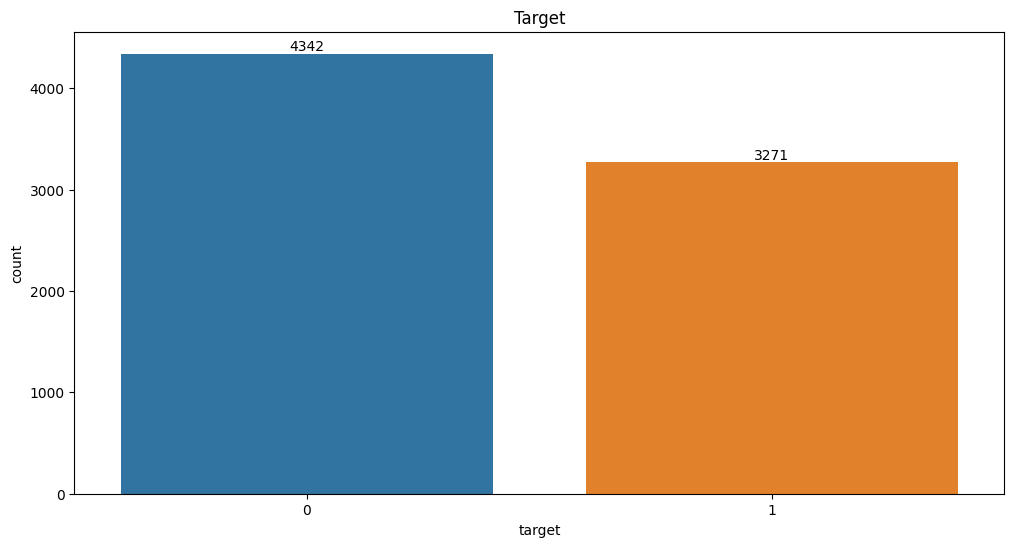

In [13]:
fig,axes = plt.subplots(figsize=(12,6))
bar = sns.countplot(training_data , x = 'target',)
for count in bar.containers:
    bar.bar_label(count)
plt.title('Target')
plt.show()

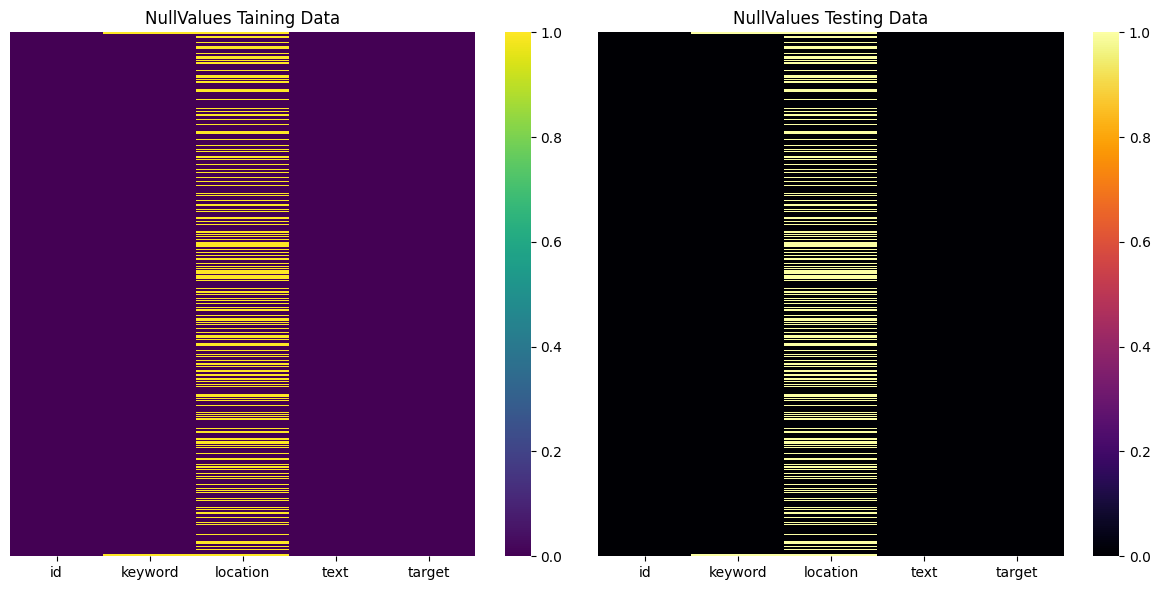

In [14]:
fig,axes = plt.subplots(1,2, figsize=(12,6))
train_null_data = training_data.isnull()
sns.heatmap(train_null_data , yticklabels=False , cmap = 'viridis',ax=axes[0])
axes[0].set_title('NullValues Taining Data')

test_null_data = testing_data.isnull()
sns.heatmap(train_null_data , yticklabels=False , cmap = 'inferno', ax=axes[1])
axes[1].set_title('NullValues Testing Data')

plt.tight_layout()
plt.show()

In [15]:
keywords = training_data['keyword'].unique().astype(str)

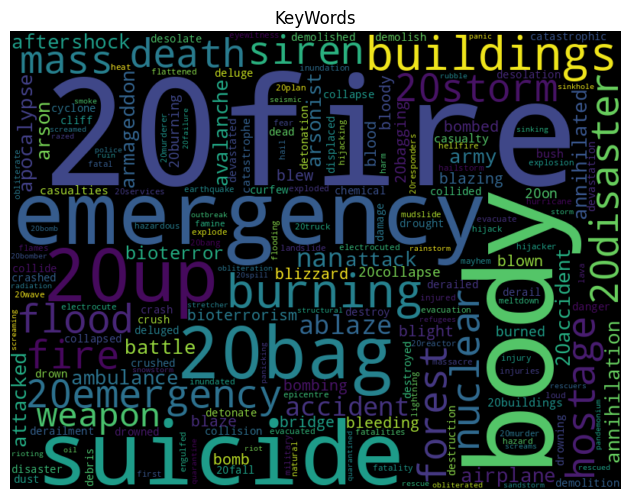

In [16]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=600 , contour_color='black').generate(' '.join(keywords))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('KeyWords')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

<Axes: xlabel='count', ylabel='keyword'>

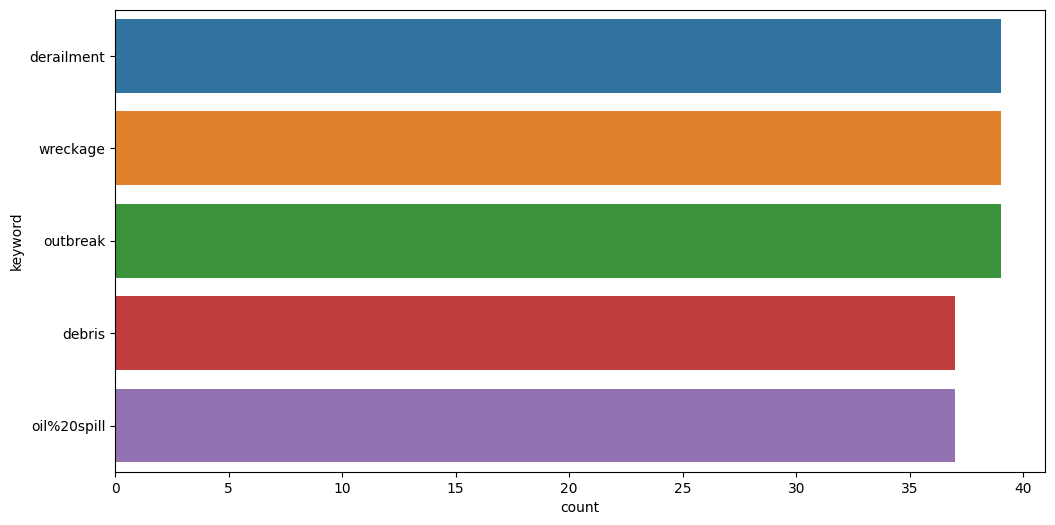

In [17]:
disaster = training_data.loc[training_data['target'] == 1]["keyword"].value_counts()
fig,axes = plt.subplots(figsize=(12,6))
sns.barplot(x=disaster[0:5],y = disaster[0:5].index)

<Axes: xlabel='count', ylabel='keyword'>

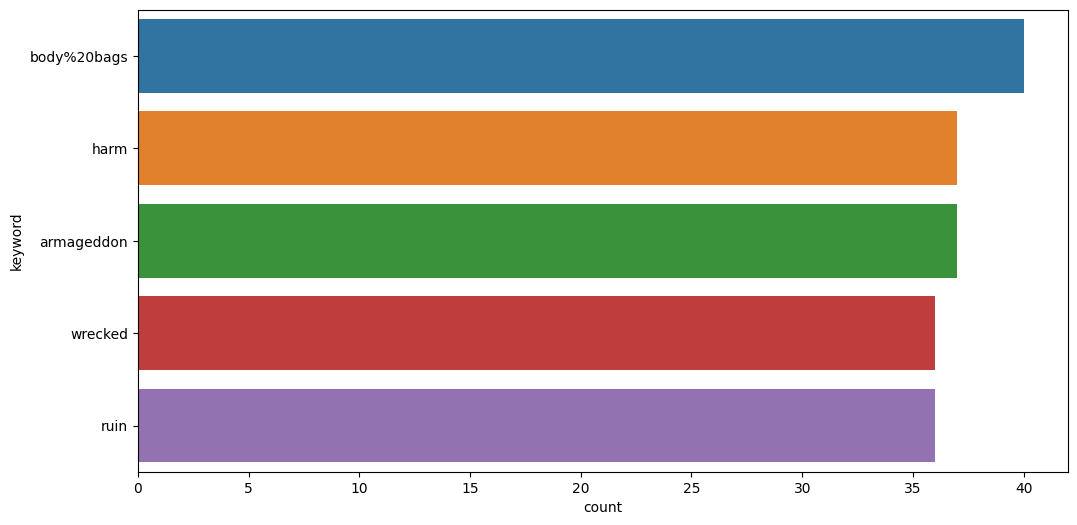

In [18]:
not_disaster = training_data.loc[training_data['target'] == 0]["keyword"].value_counts()
fig,axes = plt.subplots(figsize=(12,6))
sns.barplot(x=not_disaster[0:5],y = not_disaster[0:5].index)

In [19]:
training_data = training_data.drop('location', axis=1)

In [20]:
training_data.dropna(inplace=True)

In [21]:
training_data.head()

,id,keyword,text,target
31,48,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,Crying out for more! Set me ablaze,0
35,53,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0


In [22]:
messages = training_data.copy()
messages.head()

,id,keyword,text,target
31,48,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,Crying out for more! Set me ablaze,0
35,53,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0


In [23]:
messages.reset_index(inplace=True)
messages

,index,id,keyword,text,target
0,31,48,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
1,32,49,ablaze,We always try to bring the heavy. #metal #RT h...,0
2,33,50,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
3,34,52,ablaze,Crying out for more! Set me ablaze,0
4,35,53,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
...,...,...,...,...,...
7547,7578,10830,wrecked,@jt_ruff23 @cameronhacker and I wrecked you both,0
7548,7579,10831,wrecked,Three days off from work and they've pretty mu...,0
7549,7580,10832,wrecked,#FX #forex #trading Cramer: Iger's 3 words tha...,0
7550,7581,10833,wrecked,@engineshed Great atmosphere at the British Li...,0


In [24]:
stopwords = set(stopwords.words('english'))

In [25]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

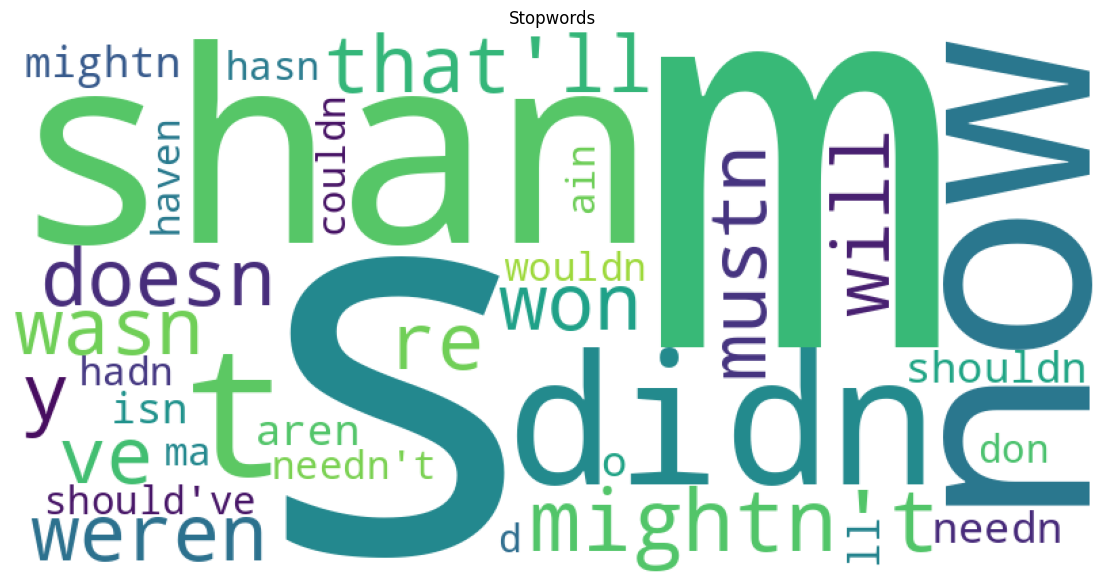

In [26]:
plt.figure(figsize=(14,8))
wordcloud = WordCloud(width=800,height=400,background_color='white').generate(' '.join(stopwords))
plt.imshow(wordcloud)
plt.title('Stopwords')
plt.axis('off')
plt.show()

In [27]:
corpus = []
for i in range(0,len(messages)):
    review = re.sub('[^a-zA-Z0-9]',' ',messages['text'][i])
    review = review.lower()
    review = review.split()
    
    review = [stemmer.stem(words) for words in review if not words in stopwords]
    review = ' '.join(review)
    corpus.append(review)

In [28]:
corpus[0]

'bbcmtd wholesal market ablaz http co lhyxeohy6c'

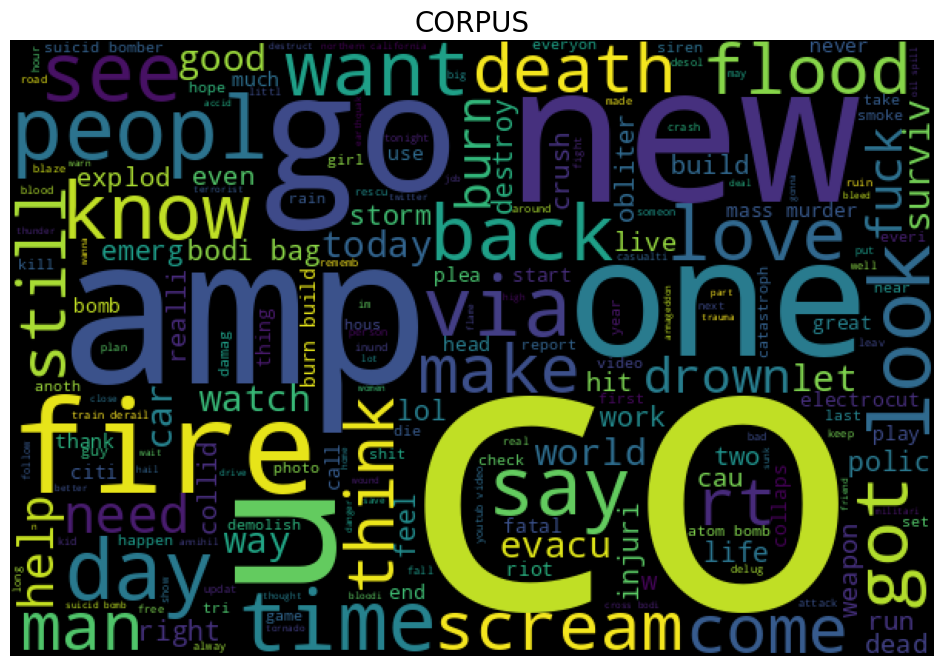

In [29]:
from wordcloud import WordCloud
plt.figure(figsize=(14,8))
wordcloud=WordCloud(width=600,height=400, contour_color='black').generate(' '.join(corpus))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('CORPUS',fontsize=20)
plt.show()

In [30]:
vocabulary_size = 5000
sentence_length = 20

In [31]:
one_hot_representation = [one_hot(words,vocabulary_size)for words in corpus]

In [32]:
one_hot_representation[1]

[1825, 492, 2081, 1115, 293, 3614, 4925, 214, 2536]

In [33]:
corpus[1]

'alway tri bring heavi metal rt http co yao1e0xngw'

In [34]:
padding = pad_sequences(one_hot_representation,maxlen=sentence_length , padding='pre')
padding[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       1825,  492, 2081, 1115,  293, 3614, 4925,  214, 2536], dtype=int32)

In [35]:
embedded_vector = 40
model = Sequential()
model.add(Embedding(vocabulary_size,embedded_vector,input_shape=(sentence_length,)))
model.add(Bidirectional(LSTM(100)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 20, 40)         │       200,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 200)            │       112,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 313,001 (1.19 MB)

 Trainable params: 313,001 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics =['accuracy'])

In [37]:
y = training_data['target']
y.head()

31    1
32    0
33    1
34    0
35    0
Name: target, dtype: int64

In [38]:
X_final = np.array(padding)
y_final = np.array(y)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

In [40]:
earlystopping = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=0,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)

In [41]:
Model= model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=32)

Epoch 1/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6383 - loss: 0.6114 - val_accuracy: 0.7737 - val_loss: 0.4928
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.8525 - loss: 0.3503 - val_accuracy: 0.7624 - val_loss: 0.5025
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8926 - loss: 0.2767 - val_accuracy: 0.7386 - val_loss: 0.5852
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9328 - loss: 0.1918 - val_accuracy: 0.7359 - val_loss: 0.7999
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9588 - loss: 0.1324 - val_accuracy: 0.7300 - val_loss: 0.8243
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9747 - loss: 0.0818 - val_accuracy: 0.7201 - val_loss: 0.9436
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9804 - loss: 0.0704 - val_accuracy: 0.7220 - val_loss: 1.1486
Epoch 8/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9832 - loss: 0.0604 - val_ac

In [42]:
Model.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

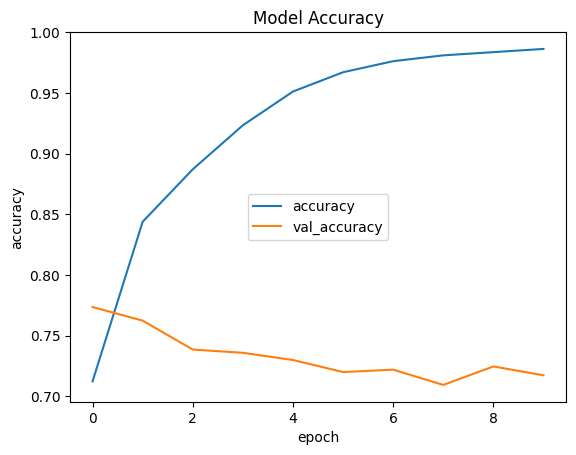

In [43]:
plt.plot(Model.history['accuracy'])
plt.plot(Model.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['accuracy','val_accuracy'],loc='center')
plt.show()

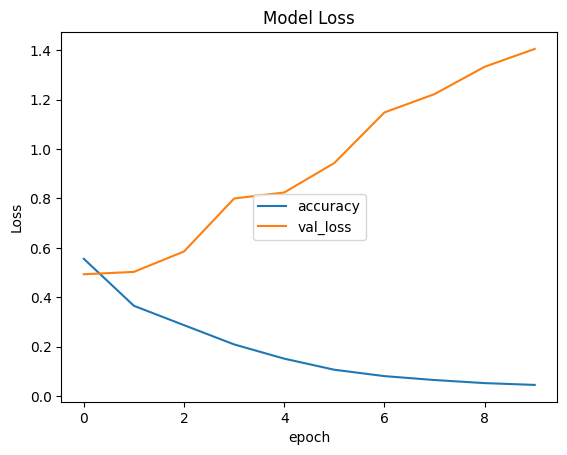

In [44]:
plt.plot(Model.history['loss'])
plt.plot(Model.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(['accuracy','val_loss'],loc='center')
plt.show()

In [45]:
messages = testing_data['text']

In [46]:
corpus = []
for i in range(0,len(messages)):
    review = re.sub('[^a-zA-Z0-9]',' ',messages[i])
    review = review.lower()
    review = review.split()
    
    review = [stemmer.stem(words) for words in review if not words in stopwords]
    review = ' '.join(review)
    corpus.append(review)

In [47]:
corpus[0]

'happen terribl car crash'

In [48]:
one_hot_representation = [one_hot(words,vocabulary_size)for words in corpus]

In [49]:
padding1 = pad_sequences(one_hot_representation,maxlen=sentence_length , padding='pre')

In [50]:
X_test = np.array(padding1)

In [51]:
prediction = model.predict(X_test)

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


In [52]:
len(prediction)

3263

In [53]:
val=[]
for i in prediction:
    val.append(i[0])

In [54]:
final_target = np.round(val).astype(int)
len(final_target)

3263

In [55]:
submission = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
submission.head() , submission.shape
submission_id = submission['id']
submission_id

0           0
1           2
2           3
3           9
4          11
        ...  
3258    10861
3259    10865
3260    10868
3261    10874
3262    10875
Name: id, Length: 3263, dtype: int64

In [56]:
submission = pd.DataFrame({'id': submission_id, 'target':final_target})
submission.to_csv('submission.csv', index=False)